# YOLO, YOLO PX, YOLO PX II method analysis and final errors for DS-IA
- Notebook of predictions, labelling and training is performed in the other one

In [ ]:
NOTEBOOK_CONFIG = {'label_mode': True,
                   'train_mode': True,
                   'IMG_LENGTH': 0.377,
                   'IMG_WIDTH': 0.143,
                   'IMG_XDIM': 143,
                   'IMG_YDIM': 377,
                   'labels_type' : "Labelsv0_detect",
                   'task' : "detect",
                   'model_name' : "YOLOv0_detect"
                   }

In [ ]:
# Folders
# Location of images
images_folder = f"../docs/Data/Images/"
# Locations of yolo's datasets
yolo_folder = f"../docs/Models/{NOTEBOOK_CONFIG['yolo_type']}/datasets/"
# Location of labels
labels_folder= f"../docs/Data/{NOTEBOOK_CONFIG['labels_type']}/"
# Location of trained models
model_folder = f"../docs/Models/{NOTEBOOK_CONFIG['yolo_type']}/"

In [ ]:
# Path for sample image
n_image = 109
image_path = f"../docs/Data/Images/gaussian_{n_image}.png"
label_path = f"../docs/Data/{NOTEBOOK_CONFIG['labels_type']}/gaussian_{n_image}.txt"

In [ ]:
# If using google colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import pandas as pd
import numpy as np

from datetime import datetime
import scipy.io

from matplotlib import pyplot as plt
from adjustText import adjust_text

In [ ]:
from ultralytics import YOLO
import cv2
from PIL import Image

# Load modules

In [ ]:
# Training runs (best)
bst_run = {'YOLOv0_detect' : '2023-07-26_18-50-24',
           'YOLOv0_E2_detect' : '2023-08-21_09-27-11',
           'YOLOv0_E3_detect' : '2023-08-21_10-25-30',
           'YOLOv0_E4_detect' : '2023-08-21_14-37-58',
           "YOLOv0_E12_detect" : "2023-08-21_13-57-46",
           'YOLOv0_T80kenji_detect' : '2023-09-04_11-19-43'}

In [ ]:
# Load custom model
base_path = "../docs/Models"
model_path = (f"{NOTEBOOK_CONFIG['model_name']}/runs/
              {bst_run[NOTEBOOK_CONFIG['model_name']]}/
              {NOTEBOOK_CONFIG['task']}")

model = YOLO(f"{base_path}/{model_path}/train/weights/best.pt")

In [1]:
import sys
sys.path.append("..")

In [ ]:
from helpers.gaussian_generator import generate_grid
from helpers.auxiliary_functions import (parameters_extract,
                                         checkpoint_error)
from helpers.aux_plotter import (plot_boxes,
                                 plot_boxes_gmm,
                                 gaussians_labelled,
                                 plot_grayscale,
                                 plot_box_labels)
from pipelines.pipelines import (ppl_fit_gaussians,
                                 ppl_error_estimation,
                                 ppl_yolo_predict_gaussians,
                                 ppl_yolo_px_predict_gaussians,
                                 ppl_ensemble_predict_gaussians)
from helpers.error_estimation import compute_error_per_gaussian

# Data from CNR

## Load
- Real size of the tile is roughly equal to 2 pixel / mm

In [ ]:
# Load 400 gaussians
mat = scipy.io.loadmat('../docs/Data/db_80beam.mat')
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'F_data', 'Fit_flux', 'beta'])


In [ ]:
# Generate GRID
x, y = generate_grid((0, NOTEBOOK_CONFIG['IMG_WIDTH']), 
                     (0, NOTEBOOK_CONFIG['IMG_LENGTH']), 
                     NOTEBOOK_CONFIG['IMG_XDIM'], 
                     NOTEBOOK_CONFIG['IMG_YDIM'])

# [ESTIMATION PART I]
- Images: 0 - 200 (Gaussians with only overlapping in y-direction)
  - All amplitudes are higher around 1.5E6 (250%)
  - x center coincides with beta xs
  - y center It has some Gaussians deslocated to up and other to down around 0.01 in y direction
  - dispersion in x Higher dispersion in x directions around 0.003 (40%)
  - dispersion in y Higher dispersion in y direction around 0.002 (40%)


## [ESTIMATION] Pipeline ppl_Yolo

### Predict with custom model - YOLOv0

In [ ]:
os.listdir("../docs/Models")

['YOLOv0_detect',
 'YOLOv0_E2_detect',
 'YOLOv0_E3_detect',
 'YOLOv0_E12_detect',
 'YOLOv0_E4_detect',
 'Archive',
 'YOLOv0_E1_detect',
 'YOLOv0_T80kenji_detect']

In [ ]:
os.listdir("../docs/Models/YOLOv0_detect/datasets/test/images/")

['gaussian_193.png',
 'gaussian_121.png',
 'gaussian_140.png',
 'gaussian_186.png',
 'gaussian_94.png',
 'gaussian_113.png',
 'gaussian_99.png',
 'gaussian_184.png',
 'gaussian_112.png',
 'gaussian_176.png',
 'gaussian_194.png',
 'gaussian_109.png',
 'gaussian_131.png',
 'gaussian_70.png',
 'gaussian_129.png',
 'gaussian_79.png',
 'gaussian_55.png',
 'gaussian_148.png',
 'gaussian_18.png',
 'gaussian_53.png']

In [ ]:
# Wrap sizes and ranges
image_ranges = [(0, NOTEBOOK_CONFIG['IMG_WIDTH']), 
                (0, NOTEBOOK_CONFIG['IMG_LENGTH'])]
image_size = [NOTEBOOK_CONFIG['IMG_XDIM'], 
              NOTEBOOK_CONFIG['IMG_YDIM']]

In [ ]:
# Make the prediction
img = cv2.imread(image_path)
results = model.predict(img)

# class 0 boxes
tensor_boxes = results[0].boxes.xyxy

# Centers
means_yolo = [(float(x),
          float(y)) for
          x,y in zip(results[0].boxes.xywhn[:, 0] * image_size[0],
                     results[0].boxes.xywhn[:, 1]  * image_size[1])]


0: 640x256 74 gaussians, 649.8ms
Speed: 19.2ms preprocess, 649.8ms inference, 29.8ms postprocess per image at shape (1, 3, 640, 256)


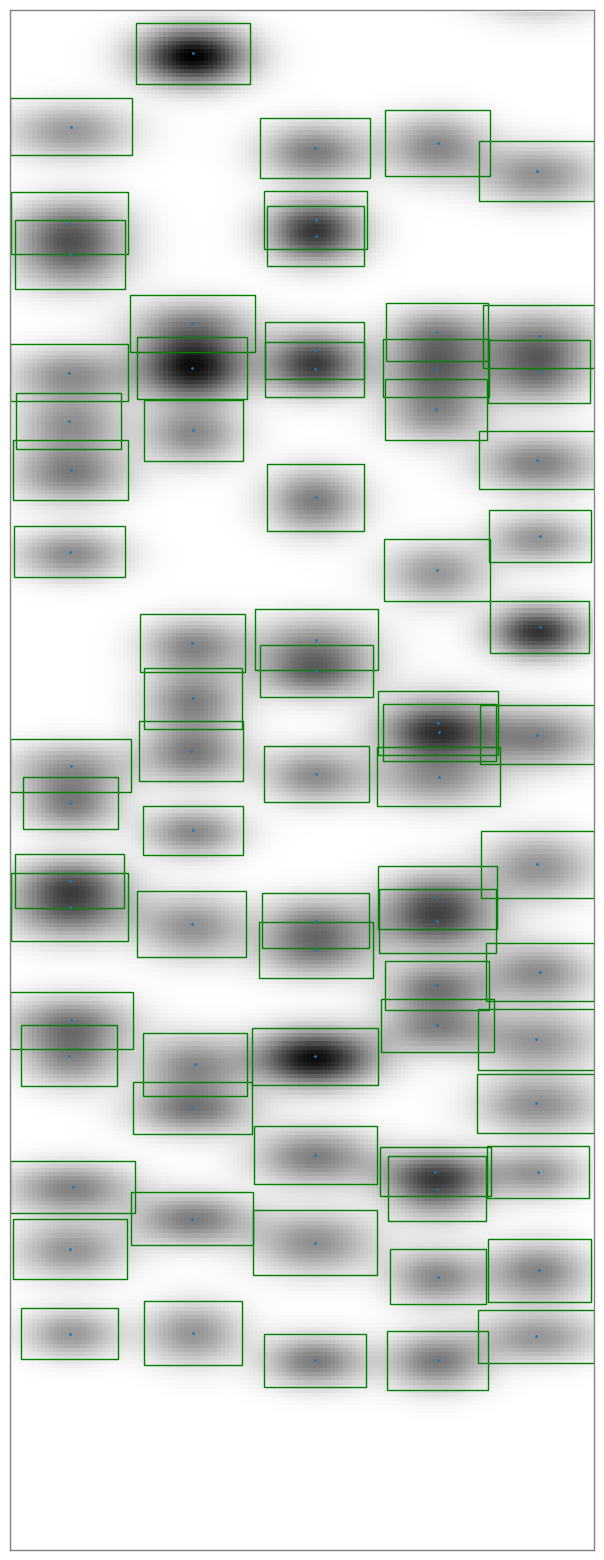

In [ ]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, ax = plt.subplots(1, figsize = (15, 20))

# Display the image and plot predicted centers
ax.imshow(im)
plot_boxes(tensor_boxes,
           ax,
           edge_color = 'g')
ax.set_ylim(ax.get_ylim()[::-1])
ax.scatter(np.array(means_yolo )[:,0], 
           np.array(means_yolo)[:, 1], s = 1)
# axs[2].axis('off')
ax.set_xlim(0, NOTEBOOK_CONFIG['IMG_XDIM'])
ax.set_ylim(0, NOTEBOOK_CONFIG['IMG_YDIM'])

ax.xaxis.label.set_text("")
ax.yaxis.label.set_text("")

ax.set_xticks([])
ax.set_yticks([])
# Change the color of the axis spines (borders)
for spine in ax.spines.values():
    spine.set_edgecolor('gray')
    spine.set_linewidth(1)

plt.show()

In [ ]:
# Estimate Gaussian - Final prediction
image = [x, y, mat['F_data'][:,:, n_image]]
(means,
 covariances,
 angles,
 amplitudes) = ppl_fit_gaussians(image,
                                 means_init = 'laplace',
                                 peak_method = 'laplace',
                                 em_iterations = 1000,
                                 covariance_gaussians_type = 'diag',
                                 n_gaussians = None,
                                 image_ranges = image_ranges,
                                 image_size = image_size,
                                 fig_size = (10, 8),
                                 plot = True,
                                 plot_points = True)

Number of indentifiable Gaussians (center in the image): 78


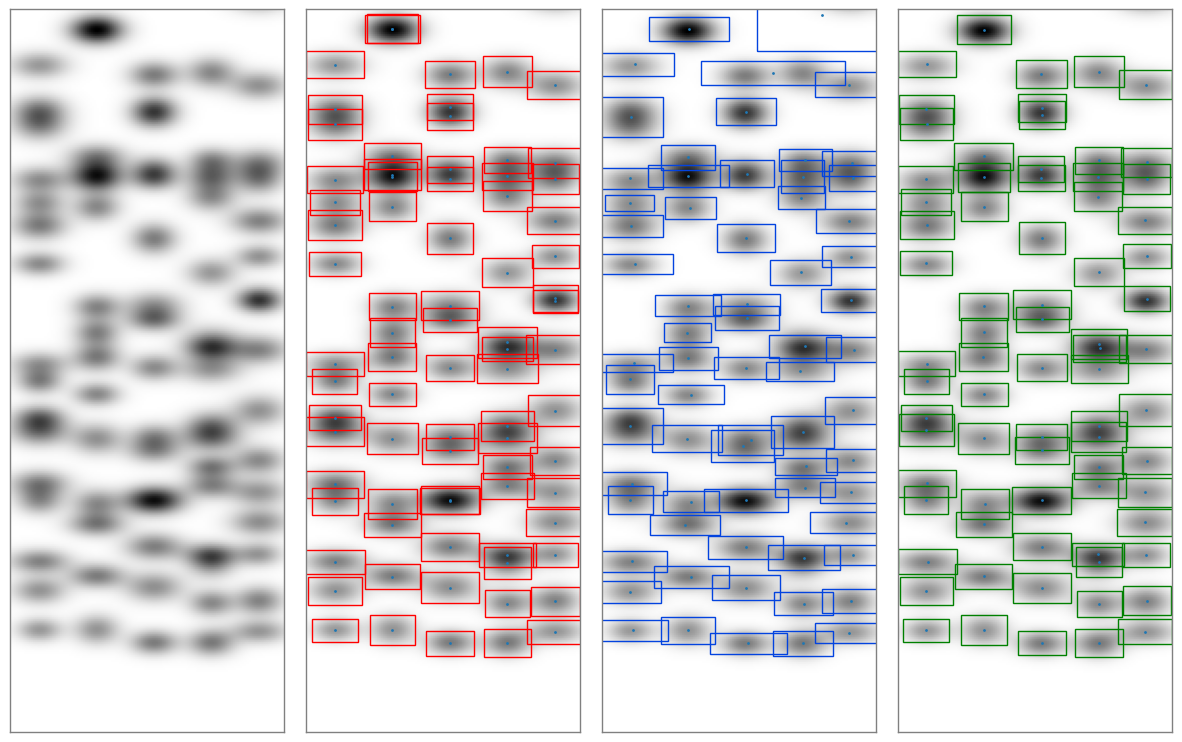

In [ ]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 4, figsize = (15, 20))

# Display the image and plot predicted centers GMM
axs[2].imshow(im)
plot_boxes_gmm(means = means,
               covariances = covariances,
               ax = axs[2],
               beta = 3,
               edge_color = '#0343DF')
axs[2].set_ylim(ax.get_ylim()[::-1])
axs[2].scatter(means[:,0] * 1000, 
               means[:, 1] * 1000, 
               s = 1)
# axs[3].axis('off')
axs[2].set_xlim(0, NOTEBOOK_CONFIG['IMG_XDIM'])
axs[2].set_ylim(0, NOTEBOOK_CONFIG['IMG_YDIM'])


# Display the image and plot predicted centers
axs[3].imshow(im)
plot_boxes(tensor_boxes,
           axs[3],
           edge_color = 'g')
axs[3].set_ylim(axs[2].get_ylim()[::-1])
axs[3].scatter(np.array(means_yolo )[:,0], 
               np.array(means_yolo)[:, 1], 
               s = 1)
# axs[2].axis('off')
axs[3].set_xlim(0, NOTEBOOK_CONFIG['IMG_XDIM'])
axs[3].set_ylim(0, NOTEBOOK_CONFIG['IMG_YDIM'])

#axs[2].set_title("Prediction")

# Labelling
x, y, z = gaussians_labelled(image_path,
                   label_path,
                   axs[1],
                   task = NOTEBOOK_CONFIG['task'],
                   colorbar = False,
                   plot_centers = True)
# axs[1].axis('off')
axs[1].set_xlim(0, NOTEBOOK_CONFIG['IMG_WIDTH'])
axs[1].set_ylim(0, NOTEBOOK_CONFIG['IMG_LENGTH'])
#axs[1].set_title("Ground Truth")

# Image
plot_grayscale(x, y, z, colorbar = False, ax = axs[0])
# axs[0].axis('off')
axs[0].set_xlim(0, NOTEBOOK_CONFIG['IMG_WIDTH'])
axs[0].set_ylim(0, NOTEBOOK_CONFIG['IMG_LENGTH'])


for ax in axs:
  ax.xaxis.label.set_text("")
  ax.yaxis.label.set_text("")

  ax.set_xticks([])
  ax.set_yticks([])
  # Change the color of the axis spines (borders)
  for spine in ax.spines.values():
      spine.set_edgecolor('gray')
      spine.set_linewidth(1)

plt.subplots_adjust(wspace= 0.08)
plt.show()

### Error evaluation

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(f"../docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
# Iterate all images - GMM method
results = {'Image' : [],
           'Number identified - YOLO' : [],
           'Number identifiable - YOLO' : [],
           'Percentage - YOLO' : [],
           'RMSE_cx - YOLO' : [],
           'RMSE_cy - YOLO' : [],
           'RMSE_c - YOLO' : [],
           'RMSE_sigmax - YOLO' : [],
           'RMSE_sigmay - YOLO' : [],
           'RMSE_sigma - YOLO' : [],
           'MaxE_sigmax - YOLO': [],
           'MaxE_sigmay - YOLO': [],
           'MaxE_sigma - YOLO': [],
           'RMSE_amplitude - YOLO': [],
           'RMSEPixel - YOLO': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       estimation_method = "YOLO",
                                       image_path = "../Data/Images/",
                                       yolo_model = model,
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 73 gaussians, 609.6ms
Speed: 2.0ms preprocess, 609.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011394           0]
  [          0   0.0065262]]]
covariances true [[[   0.011063           0]
  [          0   0.0065808]]]



0: 640x256 76 gaussians, 253.0ms
Speed: 2.2ms preprocess, 253.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013137           0]
  [          0   0.0065549]]]
covariances true [[[   0.013067           0]
  [          0   0.0065975]]]



0: 640x256 78 gaussians, 299.1ms
Speed: 2.0ms preprocess, 299.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01223           0]
  [          0   0.0075144]]]
covariances true [[[   0.012348           0]
  [          0   0.0076073]]]



0: 640x256 75 gaussians, 633.8ms
Speed: 4.3ms preprocess, 633.8ms inference, 10.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011962           0]
  [          0   0.0064669]]]
covariances true [[[   0.011904           0]
  [          0   0.0066265]]]



0: 640x256 75 gaussians, 912.4ms
Speed: 2.0ms preprocess, 912.4ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012475           0]
  [          0   0.0070943]]]
covariances true [[[   0.012563           0]
  [          0   0.0070748]]]



0: 640x256 75 gaussians, 566.2ms
Speed: 1.9ms preprocess, 566.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01373           0]
  [          0   0.0066199]]]
covariances true [[[   0.013961           0]
  [          0   0.0068123]]]



0: 640x256 76 gaussians, 1942.9ms
Speed: 12.5ms preprocess, 1942.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012146           0]
  [          0    0.006115]]]
covariances true [[[   0.012384           0]
  [          0   0.0061191]]]



0: 640x256 76 gaussians, 575.0ms
Speed: 10.5ms preprocess, 575.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013457           0]
  [          0   0.0073888]]]
covariances true [[[   0.013943           0]
  [          0   0.0075659]]]



0: 640x256 77 gaussians, 799.2ms
Speed: 2.0ms preprocess, 799.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011078           0]
  [          0   0.0072825]]]
covariances true [[[   0.011115           0]
  [          0   0.0074949]]]



0: 640x256 77 gaussians, 265.5ms
Speed: 1.9ms preprocess, 265.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011173           0]
  [          0   0.0073987]]]
covariances true [[[    0.01116           0]
  [          0   0.0074206]]]



0: 640x256 74 gaussians, 264.9ms
Speed: 2.2ms preprocess, 264.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011979           0]
  [          0   0.0069024]]]
covariances true [[[   0.012185           0]
  [          0   0.0069962]]]



0: 640x256 74 gaussians, 264.7ms
Speed: 2.2ms preprocess, 264.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014278           0]
  [          0   0.0067694]]]
covariances true [[[   0.014288           0]
  [          0   0.0067408]]]



0: 640x256 76 gaussians, 256.9ms
Speed: 1.7ms preprocess, 256.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014614           0]
  [          0   0.0063066]]]
covariances true [[[   0.014628           0]
  [          0   0.0062392]]]



0: 640x256 78 gaussians, 260.7ms
Speed: 1.9ms preprocess, 260.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012464           0]
  [          0   0.0069992]]]
covariances true [[[   0.012804           0]
  [          0   0.0072008]]]



0: 640x256 76 gaussians, 290.9ms
Speed: 2.1ms preprocess, 290.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011357           0]
  [          0   0.0072238]]]
covariances true [[[   0.011323           0]
  [          0   0.0072177]]]



0: 640x256 71 gaussians, 431.6ms
Speed: 4.4ms preprocess, 431.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01228           0]
  [          0   0.0065724]]]
covariances true [[[   0.012668           0]
  [          0   0.0067546]]]



0: 640x256 74 gaussians, 443.2ms
Speed: 4.8ms preprocess, 443.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011643           0]
  [          0   0.0071789]]]
covariances true [[[   0.011655           0]
  [          0   0.0071813]]]



0: 640x256 78 gaussians, 260.1ms
Speed: 2.0ms preprocess, 260.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013345           0]
  [          0   0.0069194]]]
covariances true [[[   0.013515           0]
  [          0   0.0070957]]]



0: 640x256 74 gaussians, 253.1ms
Speed: 1.9ms preprocess, 253.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011956           0]
  [          0   0.0067009]]]
covariances true [[[   0.011843           0]
  [          0    0.006875]]]



0: 640x256 76 gaussians, 252.9ms
Speed: 1.9ms preprocess, 252.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011865           0]
  [          0   0.0065113]]]
covariances true [[[   0.011823           0]
  [          0   0.0065817]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

,mean,std,max
Image,120.20,50.49,194.00
Number identified - YOLO,75.45,1.79,78.00
Number identifiable - YOLO,78.60,0.75,80.00
Percentage - YOLO,96.01,2.65,100.00
RMSE_cx - YOLO,1.36,1.28,5.67
RMSE_cy - YOLO,0.31,0.35,1.33
RMSE_c - YOLO,1.40,1.32,5.82
RMSE_sigmax - YOLO,2.78,0.38,3.47
RMSE_sigmay - YOLO,3.30,0.76,4.76
RMSE_sigma - YOLO,4.33,0.77,5.90


In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values('Image')

,Image,Number identified - YOLO,Number identifiable - YOLO,Percentage - YOLO,RMSE_cx - YOLO,RMSE_cy - YOLO,RMSE_c - YOLO,RMSE_sigmax - YOLO,RMSE_sigmay - YOLO,RMSE_sigma - YOLO,MaxE_sigmax - YOLO,MaxE_sigmay - YOLO,MaxE_sigma - YOLO,RMSE_amplitude - YOLO,RMSEPixel - YOLO
18,18,74,78,94.87,0.86,0.21,0.88,2.74,3.88,4.75,20.24,48.81,52.84,23.29,515643.67
19,53,76,79,96.20,0.79,0.26,0.83,3.17,4.52,5.52,13.69,44.93,46.97,36.88,921014.50
16,55,74,79,93.67,1.26,0.34,1.30,3.00,3.71,4.77,13.34,32.68,35.30,34.81,859207.70
13,70,78,78,100.00,0.80,0.19,0.82,2.97,2.94,4.18,11.20,15.69,19.28,28.87,835748.76
15,79,71,80,88.75,0.99,0.15,1.00,2.79,2.68,3.87,14.30,19.34,24.05,19.19,204533.62
4,94,75,78,96.15,1.15,0.19,1.16,2.50,2.35,3.43,10.08,10.25,14.38,29.76,740547.99
6,99,76,79,96.20,0.97,0.20,0.99,2.62,3.44,4.32,13.08,35.29,37.64,27.40,669591.88
11,109,74,78,94.87,0.90,0.14,0.91,2.42,2.02,3.15,9.67,11.79,15.25,22.40,409631.50
8,112,77,79,97.47,1.00,0.21,1.02,2.49,2.98,3.89,8.75,19.37,21.25,26.59,738832.11
5,113,75,79,94.94,4.39,1.33,4.59,3.47,4.76,5.90,19.10,65.84,68.55,28.09,726247.68


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""../docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {"../Data/Images/"}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "E1YOLO")

## [ESTIMATION] Pipeline ppl_SCIKIT_PX - PX Modified
- Center estimation using SCIKIT / Yolo
- FWHM estimation using the density distribution

In [ ]:
# Image - z intensities
image = [x, y, mat['F_data'][:,:, n_image]]

# Parameters extraction
(amplitude,
 xs,
 ys,
 dispersion_x,
 dispersion_y) = parameters_extract(mat['Fit_flux'], n_image)

In [ ]:
# Predict Yolo
(means,
 covariances,
 amplitudes_yolo) = ppl_yolo_predict_gaussians(mat,
                                               n_image,
                                               model,
                                               image_path,
                                               image_ranges = image_ranges,
                                               image_size = image_size)


0: 640x256 74 gaussians, 249.4ms
Speed: 1.8ms preprocess, 249.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Yolo and refining center and dispersion (Max Amp. and PX)
(converted_new_means,
new_covariances,
amplitudes_px,
new_means,
new_covariances_up,
new_covariances_down) = ppl_yolo_px_predict_gaussians(mat,
                                                      n_image,
                                                      model,
                                                      image_path,
                                                      px_step_size = 3)


0: 640x256 74 gaussians, 410.1ms
Speed: 1.9ms preprocess, 410.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Yolo and refining center and dispersion (Max Amp. and PX)
(converted_new_means_infer,
new_covariances_infer,
amplitudes_px_infer,
new_means_infer,
new_covariances_up_infer,
new_covariances_down_infer) = ppl_yolo_px_predict_gaussians(mat,
                                                            n_image,
                                                            model,
                                                            image_path,
                                                            px_step_size = 3,
                                                            infer_overlapping = True)


0: 640x256 74 gaussians, 245.1ms
Speed: 1.9ms preprocess, 245.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


### Evaluate - Plot truth, YOLO and PX

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, figsize = (15, 10))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x, y, mat['F_data'][:,:, n_image],
               colorbar = False,
               ax = ax)

In [ ]:
# Plot box and center - from pipeline with PX estimation covariance
all_texts = all_texts + plot_box_labels(image,
                                  [(x, y) for x, y in converted_new_means],
                                  [(wx, wy) for wx, wy in
                                   zip(np.sqrt(new_covariances[:, 0, 0]),
                                       np.sqrt(new_covariances[:, 1, 1]))],
                                  ax = ax,
                                  center_color = 'b', # CENTER COLOR
                                  annotate_gaussians = True,
                                  text_color = 'blue')

In [ ]:
# Plot box and center - TRUE
all_texts = all_texts + plot_box_labels(image,
                                        list(zip(xs, ys)),
                                        list(zip(dispersion_x, dispersion_y)),
                                        ax = ax,
                                        box_edge_color = 'g', # BOX COLOR
                                        center_color = 'g', # CENTER COLOR
                                        annotate_gaussians = True)

In [ ]:
# Plot box and center - YOLO
# Predict
(means,
 covariances,
 amplitudes) = ppl_yolo_predict_gaussians(mat,
                                          n_image,
                                          model,
                                          image_path,
                                          image_ranges = image_ranges,
                                          image_size = image_size)

# Plot box and center
plot_box_labels(image,
                [(x, y) for x, y in means],
                [(wx, wy) for wx, wy in
                  zip(np.sqrt(covariances[:, 0, 0]),
                      np.sqrt(covariances[:, 1, 1]))],
                ax = ax,
                box_edge_color = 'b', # BOX COLOR
                center_color = 'red', # CENTER COLOR
                annotate_gaussians = False)


0: 640x256 74 gaussians, 289.6ms
Speed: 2.2ms preprocess, 289.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
ax.xaxis.label.set_text("")
ax.yaxis.label.set_text("")

ax.set_xticks([])
ax.set_yticks([])
# Change the color of the axis spines (borders)
for spine in ax.spines.values():
    spine.set_edgecolor('gray')
    spine.set_linewidth(1)

ax.set_ylim(0, NOTEBOOK_CONFIG['IMG_LENGTH'])
ax.set_xlim(0, NOTEBOOK_CONFIG['IMG_WIDTH'])

(0.0, 0.143)

In [ ]:
adjust_text(all_texts)

60

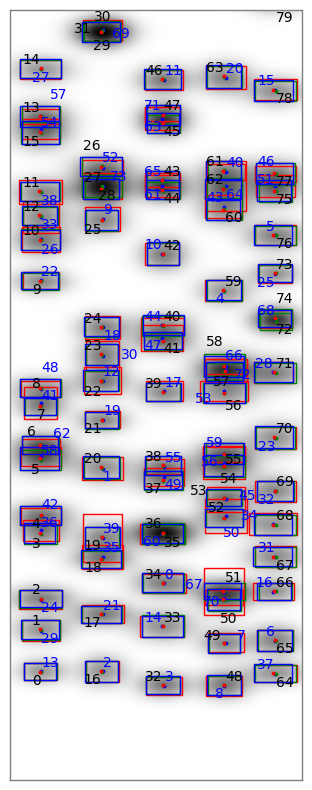

In [ ]:
plt.ion()
plt.show()

### Error evaluation - PX

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(f"../docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
# Iterate all images - GMM method
results = {'Image' : [],
           'Number identified - YOLO_px' : [],
           'Number identifiable - YOLO_px' : [],
           'Percentage - YOLO_px' : [],
           'RMSE_cx - YOLO_px' : [],
           'RMSE_cy - YOLO_px' : [],
           'RMSE_c - YOLO_px' : [],
           'RMSE_sigmax - YOLO_px' : [],
           'RMSE_sigmay - YOLO_px' : [],
           'RMSE_sigma - YOLO_px' : [],
           'MaxE_sigmax - YOLO_px': [],
           'MaxE_sigmay - YOLO_px': [],
           'MaxE_sigma - YOLO_px': [],
           'RMSE_amplitude - YOLO_px': [],
           'RMSEPixel - YOLO_px': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       estimation_method = "YOLO_px",
                                       image_path = "../docs/Data/Images/",
                                       yolo_model = model,
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 73 gaussians, 369.6ms
Speed: 4.3ms preprocess, 369.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011805           0]
  [          0   0.0066377]]]
covariances true [[[   0.011063           0]
  [          0   0.0065808]]]



0: 640x256 76 gaussians, 437.2ms
Speed: 2.0ms preprocess, 437.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014024           0]
  [          0   0.0069449]]]
covariances true [[[   0.013067           0]
  [          0   0.0065975]]]



0: 640x256 78 gaussians, 433.2ms
Speed: 2.0ms preprocess, 433.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013903           0]
  [          0   0.0078875]]]
covariances true [[[   0.012348           0]
  [          0   0.0076073]]]



0: 640x256 75 gaussians, 438.3ms
Speed: 1.9ms preprocess, 438.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012736           0]
  [          0   0.0067475]]]
covariances true [[[   0.011904           0]
  [          0   0.0066265]]]



0: 640x256 75 gaussians, 440.7ms
Speed: 1.9ms preprocess, 440.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     0.0128           0]
  [          0   0.0074786]]]
covariances true [[[   0.012563           0]
  [          0   0.0070748]]]



0: 640x256 75 gaussians, 537.0ms
Speed: 6.2ms preprocess, 537.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014575           0]
  [          0   0.0069128]]]
covariances true [[[   0.013961           0]
  [          0   0.0068123]]]



0: 640x256 76 gaussians, 670.8ms
Speed: 2.9ms preprocess, 670.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013171           0]
  [          0   0.0064714]]]
covariances true [[[   0.012384           0]
  [          0   0.0061191]]]



0: 640x256 76 gaussians, 392.3ms
Speed: 2.1ms preprocess, 392.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015063           0]
  [          0   0.0085599]]]
covariances true [[[   0.013943           0]
  [          0   0.0075659]]]



0: 640x256 77 gaussians, 503.1ms
Speed: 2.1ms preprocess, 503.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011831           0]
  [          0   0.0078093]]]
covariances true [[[   0.011115           0]
  [          0   0.0074949]]]



0: 640x256 77 gaussians, 435.6ms
Speed: 2.3ms preprocess, 435.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011919           0]
  [          0   0.0076274]]]
covariances true [[[    0.01116           0]
  [          0   0.0074206]]]



0: 640x256 74 gaussians, 487.8ms
Speed: 2.5ms preprocess, 487.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012445           0]
  [          0   0.0070312]]]
covariances true [[[   0.012185           0]
  [          0   0.0069962]]]



0: 640x256 74 gaussians, 691.9ms
Speed: 2.3ms preprocess, 691.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015129           0]
  [          0   0.0068174]]]
covariances true [[[   0.014288           0]
  [          0   0.0067408]]]



0: 640x256 76 gaussians, 409.0ms
Speed: 2.3ms preprocess, 409.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015664           0]
  [          0   0.0063754]]]
covariances true [[[   0.014628           0]
  [          0   0.0062392]]]



0: 640x256 78 gaussians, 965.5ms
Speed: 2.0ms preprocess, 965.5ms inference, 11.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013256           0]
  [          0   0.0073221]]]
covariances true [[[   0.012804           0]
  [          0   0.0072008]]]



0: 640x256 76 gaussians, 1854.4ms
Speed: 2.0ms preprocess, 1854.4ms inference, 15.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011345           0]
  [          0   0.0076519]]]
covariances true [[[   0.011323           0]
  [          0   0.0072177]]]



0: 640x256 71 gaussians, 657.4ms
Speed: 6.3ms preprocess, 657.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013697           0]
  [          0   0.0071018]]]
covariances true [[[   0.012668           0]
  [          0   0.0067546]]]



0: 640x256 74 gaussians, 519.7ms
Speed: 2.0ms preprocess, 519.7ms inference, 9.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012639           0]
  [          0   0.0071914]]]
covariances true [[[   0.011655           0]
  [          0   0.0071813]]]



0: 640x256 78 gaussians, 443.2ms
Speed: 2.0ms preprocess, 443.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013847           0]
  [          0   0.0071883]]]
covariances true [[[   0.013515           0]
  [          0   0.0070957]]]



0: 640x256 74 gaussians, 250.5ms
Speed: 2.3ms preprocess, 250.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012575           0]
  [          0   0.0070368]]]
covariances true [[[   0.011843           0]
  [          0    0.006875]]]



0: 640x256 76 gaussians, 251.9ms
Speed: 1.5ms preprocess, 251.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012586           0]
  [          0   0.0066242]]]
covariances true [[[   0.011823           0]
  [          0   0.0065817]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

,mean,std,max
Image,120.20,50.49,194.00
Number identified - YOLO_px,75.45,1.79,78.00
Number identifiable - YOLO_px,78.60,0.75,80.00
Percentage - YOLO_px,96.01,2.65,100.00
RMSE_cx - YOLO_px,0.97,1.28,5.27
RMSE_cy - YOLO_px,0.52,0.34,1.51
RMSE_c - YOLO_px,1.12,1.31,5.48
RMSE_sigmax - YOLO_px,7.24,0.72,8.53
RMSE_sigmay - YOLO_px,31.67,9.13,53.82
RMSE_sigma - YOLO_px,32.52,9.02,54.47


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""../docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {"../docs/Data/Images/"}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "E1YOLOPX")

## Evaluate - Plot Truth, YOLO and PX infer - PX Modified 2

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, figsize = (25, 20))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x, y, mat['F_data'][:,:, n_image],
               colorbar = False,
               ax = ax)

In [ ]:
# Plot box and center - from pipeline with PX estimation covariance
all_texts = all_texts + plot_box_labels(image,
                                  [(x, y) for x, y in converted_new_means_infer],
                                  [(wx, wy) for wx, wy in
                                   zip(np.sqrt(new_covariances_infer[:, 0, 0]),
                                       np.sqrt(new_covariances_infer[:, 1, 1]))],
                                  ax = ax,
                                  box_edge_color = '#0343DF', # BOX COLOR
                                  center_color = '#0343DF', # CENTER COLOR
                                  annotate_gaussians = True,
                                  text_color = 'blue')

In [ ]:
# Plot box and center - TRUE
all_texts = all_texts + plot_box_labels(image,
                                        list(zip(xs, ys)),
                                        list(zip(dispersion_x, dispersion_y)),
                                        ax = ax,
                                        box_edge_color = 'r', # BOX COLOR
                                        center_color = 'r', # CENTER COLOR
                                        annotate_gaussians = True)

In [ ]:
# Plot box and center -  YOLO
plot_box_labels(image,
                [(x, y) for x, y in means],
                [(wx, wy) for wx, wy in
                  zip(np.sqrt(covariances[:, 0, 0]),
                      np.sqrt(covariances[:, 1, 1]))],
                ax = ax,
                box_edge_color = 'g', # BOX COLOR
                center_color = 'g', # CENTER COLOR
                annotate_gaussians = False)

In [ ]:
ax.xaxis.label.set_text("")
ax.yaxis.label.set_text("")

ax.set_xticks([])
ax.set_yticks([])
# Change the color of the axis spines (borders)
for spine in ax.spines.values():
    spine.set_edgecolor('gray')
    spine.set_linewidth(1)

ax.set_ylim(0, NOTEBOOK_CONFIG['IMG_LENGTH'])
ax.set_xlim(0, NOTEBOOK_CONFIG['IMG_WIDTH'])

(0.0, 0.143)

In [ ]:
adjust_text(all_texts)

6

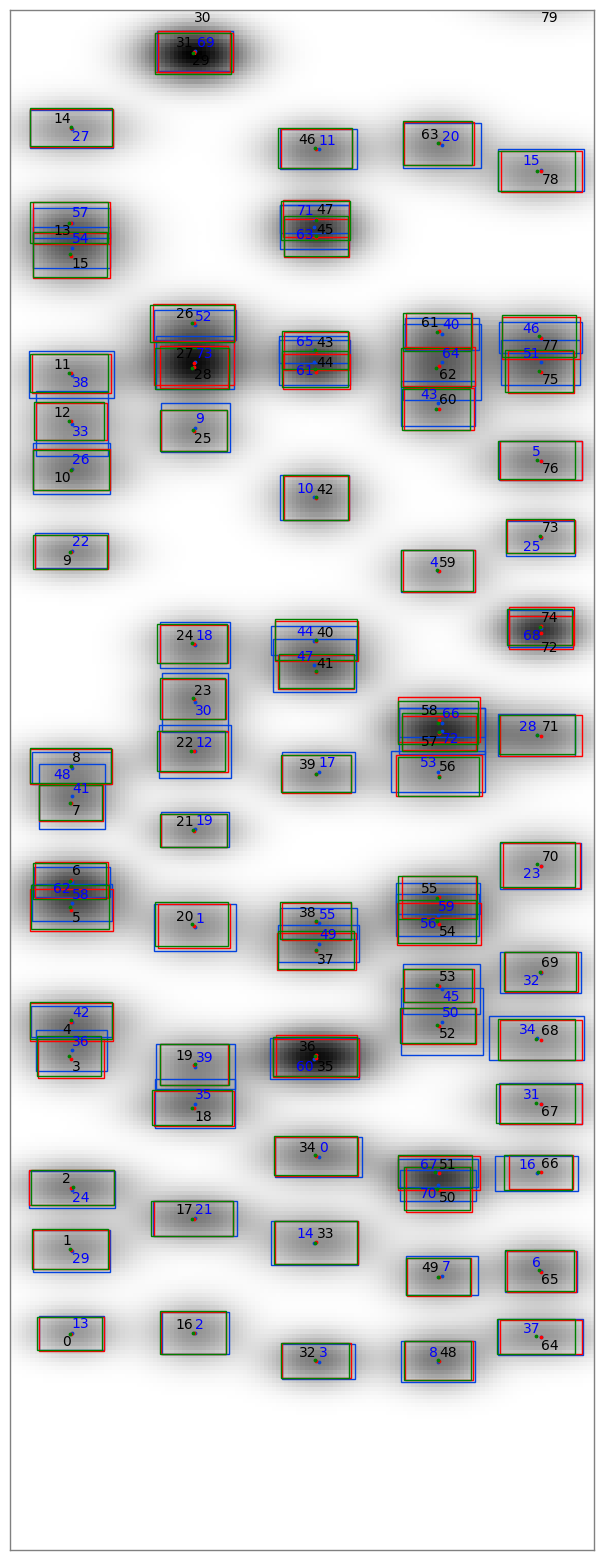

In [ ]:
plt.ion()
plt.show()

### Error evaluation - PX Infer

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(f"../docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
# Iterate all images - GMM method
results = {'Image' : [],
           'Number identified - YOLO_px_infer' : [],
           'Number identifiable - YOLO_px_infer' : [],
           'Percentage - YOLO_px_infer' : [],
           'RMSE_cx - YOLO_px_infer' : [],
           'RMSE_cy - YOLO_px_infer' : [],
           'RMSE_c - YOLO_px_infer' : [],
           'RMSE_sigmax - YOLO_px_infer' : [],
           'RMSE_sigmay - YOLO_px_infer' : [],
           'RMSE_sigma - YOLO_px_infer' : [],
           'MaxE_sigmax - YOLO_px_infer': [],
           'MaxE_sigmay - YOLO_px_infer': [],
           'MaxE_sigma - YOLO_px_infer': [],
           'RMSE_amplitude - YOLO_px_infer': [],
           'RMSEPixel - YOLO_px_infer': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       estimation_method = "YOLO_px_infer",
                                       image_path = "../docs/Data/Images/",
                                       yolo_model = model,
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 73 gaussians, 443.5ms
Speed: 2.0ms preprocess, 443.5ms inference, 8.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011805           0]
  [          0   0.0066377]]]
covariances true [[[   0.011063           0]
  [          0   0.0065808]]]



0: 640x256 76 gaussians, 250.6ms
Speed: 1.6ms preprocess, 250.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014024           0]
  [          0   0.0069449]]]
covariances true [[[   0.013067           0]
  [          0   0.0065975]]]



0: 640x256 78 gaussians, 262.0ms
Speed: 2.6ms preprocess, 262.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013903           0]
  [          0   0.0078875]]]
covariances true [[[   0.012348           0]
  [          0   0.0076073]]]



0: 640x256 75 gaussians, 431.8ms
Speed: 1.9ms preprocess, 431.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012736           0]
  [          0   0.0067475]]]
covariances true [[[   0.011904           0]
  [          0   0.0066265]]]



0: 640x256 75 gaussians, 849.3ms
Speed: 1.9ms preprocess, 849.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     0.0128           0]
  [          0   0.0074786]]]
covariances true [[[   0.012563           0]
  [          0   0.0070748]]]



0: 640x256 75 gaussians, 1556.0ms
Speed: 3.0ms preprocess, 1556.0ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014575           0]
  [          0   0.0069128]]]
covariances true [[[   0.013961           0]
  [          0   0.0068123]]]



0: 640x256 76 gaussians, 1115.6ms
Speed: 2.1ms preprocess, 1115.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013171           0]
  [          0   0.0064714]]]
covariances true [[[   0.012384           0]
  [          0   0.0061191]]]



0: 640x256 76 gaussians, 436.7ms
Speed: 1.9ms preprocess, 436.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015063           0]
  [          0   0.0085599]]]
covariances true [[[   0.013943           0]
  [          0   0.0075659]]]



0: 640x256 77 gaussians, 423.6ms
Speed: 1.9ms preprocess, 423.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011831           0]
  [          0   0.0078093]]]
covariances true [[[   0.011115           0]
  [          0   0.0074949]]]



0: 640x256 77 gaussians, 414.5ms
Speed: 2.0ms preprocess, 414.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011919           0]
  [          0   0.0076274]]]
covariances true [[[    0.01116           0]
  [          0   0.0074206]]]



0: 640x256 74 gaussians, 385.6ms
Speed: 2.4ms preprocess, 385.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012445           0]
  [          0   0.0070312]]]
covariances true [[[   0.012185           0]
  [          0   0.0069962]]]



0: 640x256 74 gaussians, 262.9ms
Speed: 1.9ms preprocess, 262.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015129           0]
  [          0   0.0068174]]]
covariances true [[[   0.014288           0]
  [          0   0.0067408]]]



0: 640x256 76 gaussians, 247.0ms
Speed: 1.7ms preprocess, 247.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015664           0]
  [          0   0.0063754]]]
covariances true [[[   0.014628           0]
  [          0   0.0062392]]]



0: 640x256 78 gaussians, 250.0ms
Speed: 2.2ms preprocess, 250.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013256           0]
  [          0   0.0073221]]]
covariances true [[[   0.012804           0]
  [          0   0.0072008]]]



0: 640x256 76 gaussians, 250.8ms
Speed: 2.1ms preprocess, 250.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011345           0]
  [          0   0.0076519]]]
covariances true [[[   0.011323           0]
  [          0   0.0072177]]]



0: 640x256 71 gaussians, 272.2ms
Speed: 2.1ms preprocess, 272.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013697           0]
  [          0   0.0071018]]]
covariances true [[[   0.012668           0]
  [          0   0.0067546]]]



0: 640x256 74 gaussians, 312.9ms
Speed: 1.9ms preprocess, 312.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012639           0]
  [          0   0.0071914]]]
covariances true [[[   0.011655           0]
  [          0   0.0071813]]]



0: 640x256 78 gaussians, 438.2ms
Speed: 3.4ms preprocess, 438.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013847           0]
  [          0   0.0071883]]]
covariances true [[[   0.013515           0]
  [          0   0.0070957]]]



0: 640x256 74 gaussians, 417.7ms
Speed: 1.9ms preprocess, 417.7ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012575           0]
  [          0   0.0070368]]]
covariances true [[[   0.011843           0]
  [          0    0.006875]]]



0: 640x256 76 gaussians, 425.0ms
Speed: 1.9ms preprocess, 425.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012586           0]
  [          0   0.0066242]]]
covariances true [[[   0.011823           0]
  [          0   0.0065817]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

,mean,std,max
Image,120.20,50.49,194.00
Number identified - YOLO_px_infer,75.45,1.79,78.00
Number identifiable - YOLO_px_infer,78.60,0.75,80.00
Percentage - YOLO_px_infer,96.01,2.65,100.00
RMSE_cx - YOLO_px_infer,0.97,1.28,5.27
RMSE_cy - YOLO_px_infer,0.52,0.34,1.51
RMSE_c - YOLO_px_infer,1.12,1.31,5.48
RMSE_sigmax - YOLO_px_infer,6.65,0.59,7.55
RMSE_sigmay - YOLO_px_infer,15.25,1.62,17.86
RMSE_sigma - YOLO_px_infer,16.66,1.56,19.28


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""../docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {"../docs/Data/Images/"}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "E1YOLOPXINFER")

## [ESTIMATION] Pipeline ensembled (PX Modified and YOLO)

In [ ]:
# Image - z intensities
image = [x,
         y,
         mat['F_data'][:,:, n_image]]

# Parameters extraction
(amplitude,
 xs,
 ys,
 dispersion_x,
 dispersion_y) = parameters_extract(mat['Fit_flux'], n_image)

#### ERROR MSEP evaluation - YOLO + Refinning -
- Compare values by reconstruction with the estimated parameters (per Gaussian)

##### Each Gaussian error estimation

In [ ]:
# Sanity check truth
means_truth = list(zip(xs, ys))
covariances_truth = [np.array([[(wx/(np.sqrt(2)))**2, 0],
                               [0, (wy/(np.sqrt(2)))**2]]) for
                     wx, wy in zip(dispersion_x, dispersion_y)]
amplitudes_truth = amplitude
(all_gaussians_truth,
 generated_z_truth,
 rmsep_truth,
 error_gaussians_truth) = compute_error_per_gaussian(image,
                                                     means_truth,
                                                     covariances_truth,
                                                     amplitudes_truth)

Gaussian 30 center is out of bounds
Gaussian 79 center is out of bounds


In [ ]:
# Compute YOLO
(all_gaussians_yolo,
 generated_z_yolo,
 rmsep_yolo,
 error_gaussians_yolo) = compute_error_per_gaussian(image,
                                                    means,
                                                    list(covariances/2),
                                                    amplitudes_yolo)

In [ ]:
# Compute YOLO + PX
(all_gaussians_px,
 generated_z_px,
 rmsep_px,
 error_gaussians_px) = compute_error_per_gaussian(image,
                                                  converted_new_means,
                                                  list(new_covariances/2),
                                                  amplitudes_px)

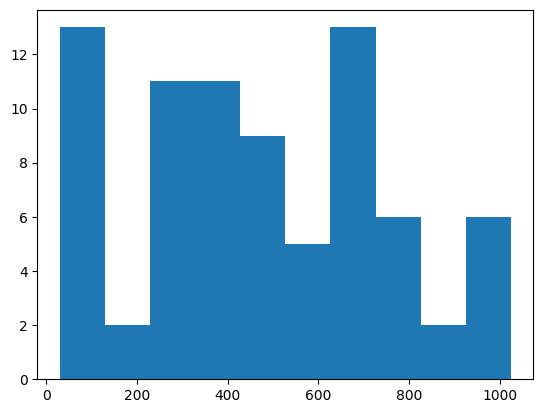

In [ ]:
# Error Yolo
plt.hist(error_gaussians_truth)
plt.show()

Max error gaussian = 72
Min error gaussian = 14


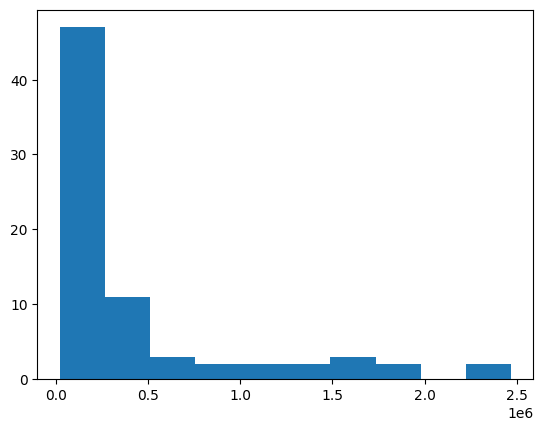

In [ ]:
# Error Yolo
plt.hist(error_gaussians_yolo)

# Gaussian min / max error
print(f'Max error gaussian = {np.argmax(np.array(error_gaussians_yolo))}')
print(f'Min error gaussian = {np.argmin(np.array(error_gaussians_yolo))}')

Max error gaussian = 70
Min error gaussian = 27


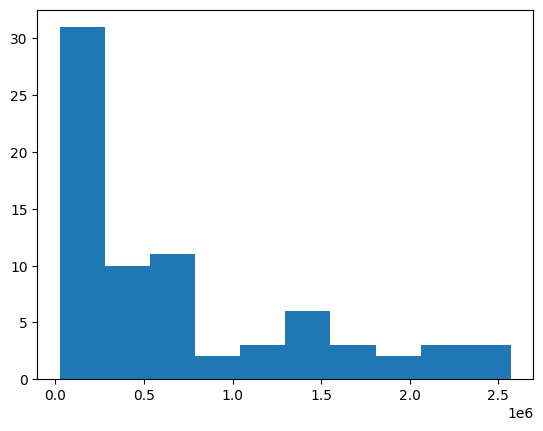

In [ ]:
# Error PX
plt.hist(error_gaussians_px)

# Gaussian min / max error
print(f'Max error gaussian = {np.argmax(np.array(error_gaussians_px))}')
print(f'Min error gaussian = {np.argmin(np.array(error_gaussians_px))}')

### Error evaluation ensemble Yolo and PX modified

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(f"../docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
# Iterate all images - ensembled method
results = {'Image' : [],
           'Number identified - ensembled' : [],
           'Number identifiable - ensembled' : [],
           'Percentage - ensembled' : [],
           'RMSE_cx - ensembled' : [],
           'RMSE_cy - ensembled' : [],
           'RMSE_c - ensembled' : [],
           'RMSE_sigmax - ensembled' : [],
           'RMSE_sigmay - ensembled' : [],
           'RMSE_sigma - ensembled' : [],
           'MaxE_sigmax - ensembled': [],
           'MaxE_sigmay - ensembled': [],
           'MaxE_sigma - ensembled': [],
           'RMSE_amplitude - ensembled': [],
           'RMSEPixel - ensembled': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       image_path = "../docs/Data/Images/",
                                       peak_method = 'laplace',
                                       yolo_model = model,
                                       estimation_method = ["YOLO", "YOLO_px"],
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 73 gaussians, 336.9ms
Speed: 2.4ms preprocess, 336.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 73 gaussians, 276.5ms
Speed: 2.4ms preprocess, 276.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011394           0]
  [          0   0.0065262]]]
covariances true [[[   0.011063           0]
  [          0   0.0065808]]]



0: 640x256 76 gaussians, 273.4ms
Speed: 2.4ms preprocess, 273.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 289.9ms
Speed: 2.7ms preprocess, 289.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013137           0]
  [          0   0.0065549]]]
covariances true [[[   0.013067           0]
  [          0   0.0065975]]]



0: 640x256 78 gaussians, 326.2ms
Speed: 1.9ms preprocess, 326.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 445.0ms
Speed: 2.0ms preprocess, 445.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01223           0]
  [          0   0.0075144]]]
covariances true [[[   0.012348           0]
  [          0   0.0076073]]]



0: 640x256 75 gaussians, 901.9ms
Speed: 2.0ms preprocess, 901.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 75 gaussians, 887.3ms
Speed: 1.8ms preprocess, 887.3ms inference, 8.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011962           0]
  [          0   0.0064669]]]
covariances true [[[   0.011904           0]
  [          0   0.0066265]]]



0: 640x256 75 gaussians, 409.4ms
Speed: 2.0ms preprocess, 409.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 75 gaussians, 283.6ms
Speed: 1.9ms preprocess, 283.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012475           0]
  [          0   0.0070943]]]
covariances true [[[   0.012563           0]
  [          0   0.0070748]]]



0: 640x256 75 gaussians, 267.7ms
Speed: 2.0ms preprocess, 267.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 75 gaussians, 268.6ms
Speed: 2.8ms preprocess, 268.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01373           0]
  [          0   0.0066199]]]
covariances true [[[   0.013961           0]
  [          0   0.0068123]]]



0: 640x256 76 gaussians, 249.5ms
Speed: 2.6ms preprocess, 249.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 258.3ms
Speed: 4.0ms preprocess, 258.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012146           0]
  [          0    0.006115]]]
covariances true [[[   0.012384           0]
  [          0   0.0061191]]]



0: 640x256 76 gaussians, 252.1ms
Speed: 2.8ms preprocess, 252.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 261.5ms
Speed: 1.9ms preprocess, 261.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013457           0]
  [          0   0.0073888]]]
covariances true [[[   0.013943           0]
  [          0   0.0075659]]]



0: 640x256 77 gaussians, 262.8ms
Speed: 2.9ms preprocess, 262.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 267.3ms
Speed: 2.0ms preprocess, 267.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011078           0]
  [          0   0.0072825]]]
covariances true [[[   0.011115           0]
  [          0   0.0074949]]]



0: 640x256 77 gaussians, 259.9ms
Speed: 2.0ms preprocess, 259.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 253.0ms
Speed: 2.0ms preprocess, 253.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011173           0]
  [          0   0.0073987]]]
covariances true [[[    0.01116           0]
  [          0   0.0074206]]]



0: 640x256 74 gaussians, 433.6ms
Speed: 2.5ms preprocess, 433.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 74 gaussians, 446.0ms
Speed: 2.0ms preprocess, 446.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011979           0]
  [          0   0.0069024]]]
covariances true [[[   0.012185           0]
  [          0   0.0069962]]]



0: 640x256 74 gaussians, 470.3ms
Speed: 1.9ms preprocess, 470.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 74 gaussians, 411.2ms
Speed: 1.9ms preprocess, 411.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014278           0]
  [          0   0.0067694]]]
covariances true [[[   0.014288           0]
  [          0   0.0067408]]]



0: 640x256 76 gaussians, 249.4ms
Speed: 2.8ms preprocess, 249.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 251.2ms
Speed: 1.8ms preprocess, 251.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014614           0]
  [          0   0.0063066]]]
covariances true [[[   0.014628           0]
  [          0   0.0062392]]]



0: 640x256 78 gaussians, 268.9ms
Speed: 2.5ms preprocess, 268.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 259.2ms
Speed: 2.5ms preprocess, 259.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012464           0]
  [          0   0.0069992]]]
covariances true [[[   0.012804           0]
  [          0   0.0072008]]]



0: 640x256 76 gaussians, 261.3ms
Speed: 1.9ms preprocess, 261.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 242.3ms
Speed: 2.4ms preprocess, 242.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011357           0]
  [          0   0.0072238]]]
covariances true [[[   0.011323           0]
  [          0   0.0072177]]]



0: 640x256 71 gaussians, 247.7ms
Speed: 4.8ms preprocess, 247.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 71 gaussians, 259.7ms
Speed: 1.8ms preprocess, 259.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01228           0]
  [          0   0.0065724]]]
covariances true [[[   0.012668           0]
  [          0   0.0067546]]]



0: 640x256 74 gaussians, 275.1ms
Speed: 2.8ms preprocess, 275.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 74 gaussians, 249.4ms
Speed: 2.7ms preprocess, 249.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011643           0]
  [          0   0.0071789]]]
covariances true [[[   0.011655           0]
  [          0   0.0071813]]]



0: 640x256 78 gaussians, 256.6ms
Speed: 1.8ms preprocess, 256.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 257.8ms
Speed: 2.0ms preprocess, 257.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013345           0]
  [          0   0.0069194]]]
covariances true [[[   0.013515           0]
  [          0   0.0070957]]]



0: 640x256 74 gaussians, 442.5ms
Speed: 2.0ms preprocess, 442.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 74 gaussians, 445.7ms
Speed: 1.9ms preprocess, 445.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011956           0]
  [          0   0.0067009]]]
covariances true [[[   0.011843           0]
  [          0    0.006875]]]



0: 640x256 76 gaussians, 448.8ms
Speed: 1.9ms preprocess, 448.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 469.9ms
Speed: 1.7ms preprocess, 469.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011865           0]
  [          0   0.0065113]]]
covariances true [[[   0.011823           0]
  [          0   0.0065817]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

,mean,std,max
Image,120.20,50.49,194.00
Number identified - ensembled,75.45,1.79,78.00
Number identifiable - ensembled,78.60,0.75,80.00
Percentage - ensembled,96.01,2.65,100.00
RMSE_cx - ensembled,1.30,1.28,5.64
RMSE_cy - ensembled,0.31,0.35,1.33
RMSE_c - ensembled,1.34,1.33,5.79
RMSE_sigmax - ensembled,2.72,0.39,3.39
RMSE_sigmay - ensembled,3.30,0.76,4.88
RMSE_sigma - ensembled,4.30,0.76,5.86


In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values('Image')

,Image,Number identified - ensembled,Number identifiable - ensembled,Percentage - ensembled,RMSE_cx - ensembled,RMSE_cy - ensembled,RMSE_c - ensembled,RMSE_sigmax - ensembled,RMSE_sigmay - ensembled,RMSE_sigma - ensembled,MaxE_sigmax - ensembled,MaxE_sigmay - ensembled,MaxE_sigma - ensembled,RMSE_amplitude - ensembled,RMSEPixel - ensembled
18,18,74,78,94.87,0.71,0.20,0.74,2.98,4.07,5.04,20.24,48.81,52.84,23.70,502329.32
19,53,76,79,96.20,0.78,0.24,0.81,3.08,4.17,5.18,13.69,40.09,42.36,36.18,916105.33
16,55,74,79,93.67,1.26,0.33,1.30,3.06,4.21,5.20,13.34,37.33,39.64,34.68,861068.90
13,70,78,78,100.00,0.75,0.19,0.78,2.91,2.94,4.14,11.20,15.69,19.28,28.85,835254.13
15,79,71,80,88.75,0.93,0.16,0.94,2.64,2.74,3.81,14.30,19.34,24.05,19.70,199943.82
4,94,75,78,96.15,1.06,0.19,1.08,2.48,2.35,3.42,10.08,10.25,14.38,29.73,740093.70
6,99,76,79,96.20,0.88,0.20,0.91,2.46,3.47,4.25,14.22,35.29,38.05,27.45,663152.70
11,109,74,78,94.87,0.85,0.14,0.86,2.36,1.99,3.09,9.67,11.79,15.25,22.34,406058.16
8,112,77,79,97.47,0.87,0.20,0.89,2.48,2.97,3.87,8.75,19.37,21.25,26.50,736875.21
5,113,75,79,94.94,4.32,1.33,4.52,3.25,4.88,5.86,19.10,65.84,68.55,28.10,720441.52


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""../docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {"../docs/Data/Images/"}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "E1YOLOENSEBPX")

### Error evaluation ensemble Yolo and PX Modified 2

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(f"../docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
# Iterate all images - ensembled method
results = {'Image' : [],
           'Number identified - ensembled' : [],
           'Number identifiable - ensembled' : [],
           'Percentage - ensembled' : [],
           'RMSE_cx - ensembled' : [],
           'RMSE_cy - ensembled' : [],
           'RMSE_c - ensembled' : [],
           'RMSE_sigmax - ensembled' : [],
           'RMSE_sigmay - ensembled' : [],
           'RMSE_sigma - ensembled' : [],
           'MaxE_sigmax - ensembled': [],
           'MaxE_sigmay - ensembled': [],
           'MaxE_sigma - ensembled': [],
           'RMSE_amplitude - ensembled': [],
           'RMSEPixel - ensembled': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       image_path = "../docs/Data/Images/",
                                       peak_method = 'laplace',
                                       yolo_model = model,
                                       estimation_method = ["YOLO", "YOLO_px_infer"],
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 73 gaussians, 770.1ms
Speed: 1.9ms preprocess, 770.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 73 gaussians, 267.8ms
Speed: 2.0ms preprocess, 267.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011394           0]
  [          0   0.0065262]]]
covariances true [[[   0.011063           0]
  [          0   0.0065808]]]



0: 640x256 76 gaussians, 279.3ms
Speed: 2.5ms preprocess, 279.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 249.2ms
Speed: 2.0ms preprocess, 249.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013137           0]
  [          0   0.0065549]]]
covariances true [[[   0.013067           0]
  [          0   0.0065975]]]



0: 640x256 78 gaussians, 257.7ms
Speed: 3.0ms preprocess, 257.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 239.3ms
Speed: 2.5ms preprocess, 239.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01223           0]
  [          0   0.0075144]]]
covariances true [[[   0.012348           0]
  [          0   0.0076073]]]



0: 640x256 75 gaussians, 246.6ms
Speed: 1.9ms preprocess, 246.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 75 gaussians, 250.6ms
Speed: 4.6ms preprocess, 250.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011962           0]
  [          0   0.0064669]]]
covariances true [[[   0.011904           0]
  [          0   0.0066265]]]



0: 640x256 75 gaussians, 253.8ms
Speed: 2.4ms preprocess, 253.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 75 gaussians, 246.4ms
Speed: 1.9ms preprocess, 246.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012475           0]
  [          0   0.0070943]]]
covariances true [[[   0.012563           0]
  [          0   0.0070748]]]



0: 640x256 75 gaussians, 343.3ms
Speed: 1.5ms preprocess, 343.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 75 gaussians, 439.1ms
Speed: 1.9ms preprocess, 439.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01373           0]
  [          0   0.0066199]]]
covariances true [[[   0.013961           0]
  [          0   0.0068123]]]



0: 640x256 76 gaussians, 533.3ms
Speed: 2.0ms preprocess, 533.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 962.6ms
Speed: 3.2ms preprocess, 962.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012146           0]
  [          0    0.006115]]]
covariances true [[[   0.012384           0]
  [          0   0.0061191]]]



0: 640x256 76 gaussians, 426.8ms
Speed: 2.0ms preprocess, 426.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 439.8ms
Speed: 2.1ms preprocess, 439.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013457           0]
  [          0   0.0073888]]]
covariances true [[[   0.013943           0]
  [          0   0.0075659]]]



0: 640x256 77 gaussians, 474.9ms
Speed: 2.0ms preprocess, 474.9ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 345.2ms
Speed: 3.9ms preprocess, 345.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011078           0]
  [          0   0.0072825]]]
covariances true [[[   0.011115           0]
  [          0   0.0074949]]]



0: 640x256 77 gaussians, 257.2ms
Speed: 1.9ms preprocess, 257.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 257.5ms
Speed: 1.9ms preprocess, 257.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011173           0]
  [          0   0.0073987]]]
covariances true [[[    0.01116           0]
  [          0   0.0074206]]]



0: 640x256 74 gaussians, 256.0ms
Speed: 2.0ms preprocess, 256.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 74 gaussians, 245.6ms
Speed: 1.9ms preprocess, 245.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012445           0]
  [          0   0.0070312]]]
covariances true [[[   0.012185           0]
  [          0   0.0069962]]]



0: 640x256 74 gaussians, 248.1ms
Speed: 1.5ms preprocess, 248.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 74 gaussians, 275.5ms
Speed: 2.1ms preprocess, 275.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014278           0]
  [          0   0.0067694]]]
covariances true [[[   0.014288           0]
  [          0   0.0067408]]]



0: 640x256 76 gaussians, 435.1ms
Speed: 2.0ms preprocess, 435.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 428.1ms
Speed: 2.0ms preprocess, 428.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014614           0]
  [          0   0.0063066]]]
covariances true [[[   0.014628           0]
  [          0   0.0062392]]]



0: 640x256 78 gaussians, 445.3ms
Speed: 2.0ms preprocess, 445.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 434.2ms
Speed: 2.0ms preprocess, 434.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012464           0]
  [          0   0.0069992]]]
covariances true [[[   0.012804           0]
  [          0   0.0072008]]]



0: 640x256 76 gaussians, 272.9ms
Speed: 2.1ms preprocess, 272.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 246.3ms
Speed: 2.1ms preprocess, 246.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011357           0]
  [          0   0.0072238]]]
covariances true [[[   0.011323           0]
  [          0   0.0072177]]]



0: 640x256 71 gaussians, 257.4ms
Speed: 2.8ms preprocess, 257.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 71 gaussians, 252.4ms
Speed: 2.2ms preprocess, 252.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01228           0]
  [          0   0.0065724]]]
covariances true [[[   0.012668           0]
  [          0   0.0067546]]]



0: 640x256 74 gaussians, 250.8ms
Speed: 1.7ms preprocess, 250.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 74 gaussians, 257.7ms
Speed: 2.1ms preprocess, 257.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011643           0]
  [          0   0.0071789]]]
covariances true [[[   0.011655           0]
  [          0   0.0071813]]]



0: 640x256 78 gaussians, 258.5ms
Speed: 1.8ms preprocess, 258.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 244.6ms
Speed: 2.0ms preprocess, 244.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013345           0]
  [          0   0.0069194]]]
covariances true [[[   0.013515           0]
  [          0   0.0070957]]]



0: 640x256 74 gaussians, 250.7ms
Speed: 3.2ms preprocess, 250.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 74 gaussians, 269.5ms
Speed: 2.4ms preprocess, 269.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011956           0]
  [          0   0.0067009]]]
covariances true [[[   0.011843           0]
  [          0    0.006875]]]



0: 640x256 76 gaussians, 262.5ms
Speed: 1.8ms preprocess, 262.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 251.0ms
Speed: 2.1ms preprocess, 251.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011865           0]
  [          0   0.0065113]]]
covariances true [[[   0.011823           0]
  [          0   0.0065817]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

,mean,std,max
Image,120.20,50.49,194.00
Number identified - ensembled,75.45,1.79,78.00
Number identifiable - ensembled,78.60,0.75,80.00
Percentage - ensembled,96.01,2.65,100.00
RMSE_cx - ensembled,1.28,1.29,5.64
RMSE_cy - ensembled,0.31,0.35,1.33
RMSE_c - ensembled,1.31,1.33,5.79
RMSE_sigmax - ensembled,2.72,0.37,3.39
RMSE_sigmay - ensembled,3.37,0.75,5.06
RMSE_sigma - ensembled,4.35,0.74,5.94


In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values('Image')

,Image,Number identified - ensembled,Number identifiable - ensembled,Percentage - ensembled,RMSE_cx - ensembled,RMSE_cy - ensembled,RMSE_c - ensembled,RMSE_sigmax - ensembled,RMSE_sigmay - ensembled,RMSE_sigma - ensembled,MaxE_sigmax - ensembled,MaxE_sigmay - ensembled,MaxE_sigma - ensembled,RMSE_amplitude - ensembled,RMSEPixel - ensembled
18,18,74,78,94.87,0.71,0.20,0.74,2.98,4.07,5.04,20.24,48.81,52.84,23.70,502329.32
19,53,76,79,96.20,0.75,0.24,0.78,2.99,4.21,5.16,13.69,40.09,42.36,36.15,915570.33
16,55,74,79,93.67,1.24,0.33,1.28,3.12,4.14,5.19,13.34,37.33,39.64,34.64,859222.85
13,70,78,78,100.00,0.73,0.19,0.76,2.87,2.95,4.12,11.20,15.69,19.28,28.86,834726.56
15,79,71,80,88.75,0.86,0.17,0.87,2.63,2.84,3.87,14.63,19.34,24.25,19.62,196985.69
4,94,75,78,96.15,1.05,0.18,1.07,2.48,2.47,3.49,10.08,10.25,14.38,29.85,738793.98
6,99,76,79,96.20,0.88,0.20,0.91,2.46,3.47,4.25,14.22,35.29,38.05,27.45,663152.70
11,109,74,78,94.87,0.83,0.14,0.85,2.30,2.04,3.07,9.67,11.79,15.25,22.35,405383.25
8,112,77,79,97.47,0.85,0.20,0.87,2.51,3.34,4.17,8.75,27.86,29.21,26.66,742708.53
5,113,75,79,94.94,4.30,1.33,4.50,3.11,5.06,5.94,19.10,65.84,68.55,28.07,719003.70


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""../docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {"../docs/Data/Images/"}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "E1YOLOENSEBPXINFER")

### Whole image generate - plotting Ensemble

In [ ]:
# Load data
n_image = 140

# Image - z intensities
image = [x,
         y,
         mat['F_data'][:,:, n_image]]

# Parameters extraction
(amplitude,
 xs,
 ys,
 dispersion_x,
 dispersion_y) = parameters_extract(mat['Fit_flux'], n_image)

In [ ]:
# Predict Yolo
(means,
 covariances,
 amplitudes_yolo) = ppl_yolo_predict_gaussians(mat,
                                               n_image,
                                               model,
                                               image_path,
                                               image_ranges = image_ranges,
                                               image_size = image_size)


0: 640x256 78 gaussians, 735.1ms
Speed: 2.1ms preprocess, 735.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Yolo and refining center and dispersion (Max Amp. and PX)
(converted_new_means_infer,
new_covariances_infer,
amplitudes_px_infer,
new_means_infer,
new_covariances_up_infer,
new_covariances_down_infer) = ppl_yolo_px_predict_gaussians(mat,
                                                            n_image,
                                                            model,
                                                            image_path,
                                                            px_step_size = 3,
                                                            infer_overlapping = True)

# Sanity check truth
means_truth = list(zip(xs, ys))
covariances_truth = [np.array([[(wx/(np.sqrt(2)))**2, 0],
                               [0, (wy/(np.sqrt(2)))**2]]) for
                     wx, wy in zip(dispersion_x, dispersion_y)]
amplitudes_truth = amplitude
(all_gaussians_truth,
 generated_z_truth,
 rmsep_truth,
 error_gaussians_truth) = compute_error_per_gaussian(image,
                                                     means_truth,
                                                     covariances_truth,
                                                     amplitudes_truth)


0: 640x256 78 gaussians, 416.7ms
Speed: 7.1ms preprocess, 416.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


Gaussian 15 center is out of bounds
Gaussian 30 center is out of bounds


In [ ]:
# Compute YOLO
(all_gaussians_yolo,
 generated_z_yolo,
 rmsep_yolo,
 error_gaussians_yolo) = compute_error_per_gaussian(image,
                                                    means,
                                                    list(covariances/2),
                                                    amplitudes_yolo)

In [ ]:
# Compute YOLO + PX
(all_gaussians_px,
 generated_z_px,
 rmsep_px,
 error_gaussians_px) = compute_error_per_gaussian(image,
                                                  converted_new_means_infer,
                                                  list(new_covariances_infer/2),
                                                  amplitudes_px_infer)

In [ ]:
all_gaussians_ensembled = ppl_ensemble_predict_gaussians(n_image,
                                      mat_data = mat,
                                      estimation_method = ["YOLO", "YOLO_px_infer"],
                                      peak_method = None,
                                      image_path = image_path,
                                      yolo_model = model,
                                      print_bettersecond = True)


0: 640x256 78 gaussians, 387.4ms
Speed: 2.6ms preprocess, 387.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 277.4ms
Speed: 1.9ms preprocess, 277.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[13, 28, 59, 67]


In [ ]:
# Error of the ensemble
(all_gaussians_ensembled,
generated_z_ensembled,
rmsep_ensembled,
error_gaussians_ensembled) = compute_error_per_gaussian(image,
                                  [i[0] for i in all_gaussians_ensembled],
                                  list(np.array([i[1] for i in
                                                all_gaussians_ensembled])/2),
                                  [i[2] for i in all_gaussians_ensembled])

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, 4, figsize = (15, 10))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x,
               y,
               image[2],
               colorbar = False,
               ax = ax[0])
ax[1].set_xlabel("x - Truth")

# Yolo Image
plot_grayscale(x,
               y,
               generated_z_yolo,
               colorbar = False,
               ax = ax[2])
ax[2].set_xlabel("x - YOLO")

# PX image
plot_grayscale(x,
               y,
               generated_z_px,
               colorbar = False,
               ax = ax[3])
ax[3].set_xlabel("x - PX Infer")

# PX image
plot_grayscale(x,
               y,
               generated_z_ensembled,
               colorbar = False,
               ax = ax[1])
ax[1].set_xlabel("x - Ensembled")

Text(0.5, 0, 'x - Ensembled')

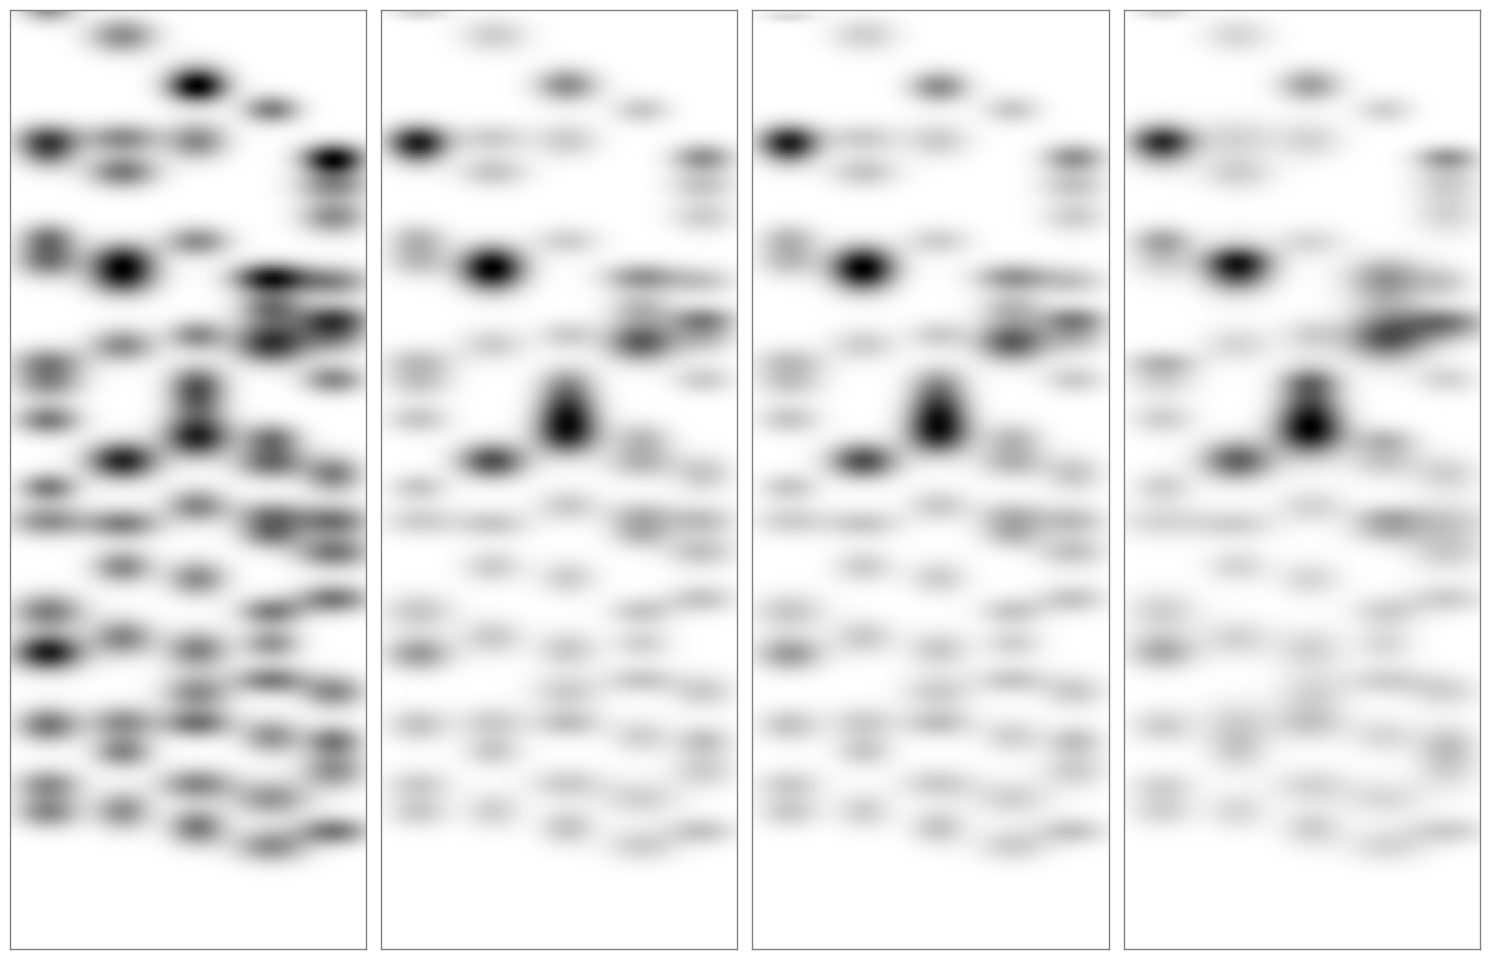

In [ ]:
plt.ion()
plt.tight_layout()
plt.show()

# Annotations

## SPIDER
- Radius of each hole in the grid is 14 mm (hemsworth1996 - Original NB design);
- Design assumed the beams as two Gaussian parts, core with the 85% power with divergence of 5 mrad and the halo (15% power) with poor divergence of > 15 mrad (hemsworth1996 - Original NB design);
- Expected core beamlet divergence of as low as 2 - 3 mrad (hemsworth1996 - reference 11)